# **M2 Experiment**

In [1]:
#connect my colab to my drive
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
RUN_SHAP_SUMMARY = True  # Set to False after first run

#**Data Loading, Cleaning and Processing**
In M2, the same dataset used in M1 is used, however preprocessing methods are different.

**Previous Note on Accountability:**

The data came with different issues which seems like the data is collected directly from sensors without much refinements. Such issues have to be taken care of by the responsible actors involved in this phase, such as data engineers. Neglecting such red flags can have a negetive impact on an AI model. For example, such empty columns and commas as floating point can contibute multiple bugs to the model and therefore worse performance.

### **Data preparation**
In this stage the following steps and methods will be carried out:


1. Loading the dataset and handling delimiter attribute   
2. Timestamp Parsing
3. Dropping empty columns
5. Rename columns/variables
6. covertind floating points from a comma (,) to a period (.).
7. Converting numerical attributes' datatype from object to float64 while time column is converted to `datetime` datatype.
  



In [3]:
import pandas as pd

file_path = 'StationDataset.csv'

# Assuming the delimiter is a semicolon (;), change it if needed
try:
    df = pd.read_csv(file_path, delimiter=';')

    # Rename columns and parse timestamp
    new_columns = {
        'Time(year-month-day h:m:s)': 'time',
        'Total solar irradiance (W/m2)': 'TSI',
        'Direct normal irradiance (W/m2)': 'DNI',
        'Global horizontal irradiance (W/m2)': 'GHI',
        'Air temperature  (°C) ': 'Air_T',
        'Atmosphere (hpa)': 'Air_P',
        'Relative humidity (%)': 'Air_H'
    }
    df = df.rename(columns=new_columns)

    # Remove empty columns
    df = df.dropna(axis=1, how='all')

    # Convert 'time' column to datetime objects
    try:
        df['time'] = pd.to_datetime(df['time'])
    except ValueError as e:
        print(f"Error converting 'time' column to datetime: {e}")
        print("Trying alternative parsing...")
    # Iterate through the columns, excluding 'time', to handle conversion of object columns
    for column in df.columns:
        if df[column].dtype == 'object' and column != 'time':  # Exclude the 'time' column
            # Replace commas with periods for decimal separators
            df[column] = df[column].str.replace(',', '.')

            # Convert to numeric
            df[column] = pd.to_numeric(df[column], errors='coerce')

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
    print(f"Error: Could not parse the DSV file at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
# Display the first few rows to confirm import
print(df.head())

# Show the data types of the columns
print(df.dtypes)

                 time  TSI  DNI  GHI  Air_T   Air_P  Air_H  Power (MW)
0 2019-01-01 00:00:00  0.0  0.0  0.0  11.90  837.20  53.06         0.0
1 2019-01-01 00:15:00  0.0  0.0  0.0  11.60  837.25  54.76         0.0
2 2019-01-01 00:30:00  0.0  0.0  0.0  11.36  837.21  57.16         0.0
3 2019-01-01 00:45:00  0.0  0.0  0.0  11.31  837.20  58.73         0.0
4 2019-01-01 01:00:00  0.0  0.0  0.0  11.26  837.09  59.93         0.0
time          datetime64[ns]
TSI                  float64
DNI                  float64
GHI                  float64
Air_T                float64
Air_P                float64
Air_H                float64
Power (MW)           float64
dtype: object


## **Handling Missing data with kNN imputation**

Unlike in M1, kNN imputation method is applied instead of linear interpolation method of M1 experiment.

**1. Check for missing values**

In [4]:
# prompt: first, find the missing values do not imput!

# Find missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 time            0
TSI           574
DNI           574
GHI           574
Air_T         574
Air_P         574
Air_H         574
Power (MW)      0
dtype: int64


**2. kNN imputation**

In [5]:
import pandas as pd
from sklearn.impute import KNNImputer

# Select numerical columns for imputation (exclude 'time')
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Ensure we are not including the non-numeric columns like 'timestamp', 'hour_sin', 'hour_cos', 'month_sin', etc.
# Remove temporal or non-numeric features that shouldn't be part of the imputation
numerical_cols = [col for col in numerical_cols if col not in ['hour', 'day_of_week', 'week', 'month', 'year', 'timestamp', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']]

# Print the columns selected for imputation
print("Columns selected for imputation:", numerical_cols)

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)  # Adjust the number of neighbors as needed

# Perform the imputation on the selected numerical columns
imputed_values = imputer.fit_transform(df[numerical_cols])

# Print the shape of the imputed values to debug
print("Shape of imputed values:", imputed_values.shape)

# Check if the imputed values shape matches the columns
if imputed_values.shape[1] != len(numerical_cols):
    print(f"Warning: Column mismatch! Expected {len(numerical_cols)} columns, but got {imputed_values.shape[1]}.")

# Convert the imputed values back into a DataFrame with the correct column names and original index
imputed_df = pd.DataFrame(imputed_values, columns=numerical_cols, index=df.index)

# Update the original DataFrame with the imputed values
df[numerical_cols] = imputed_df

# Check for missing values after imputation
missing_values_after = df.isnull().sum()
print("\nMissing values after imputation per column:\n", missing_values_after)


Columns selected for imputation: ['TSI', 'DNI', 'GHI', 'Air_T', 'Air_P', 'Air_H', 'Power (MW)']
Shape of imputed values: (70176, 7)

Missing values after imputation per column:
 time          0
TSI           0
DNI           0
GHI           0
Air_T         0
Air_P         0
Air_H         0
Power (MW)    0
dtype: int64


## **Outliers Management**
In this experiment more advanced method namely Interquartile Range (IQR) and scatter plot is used here to visualise them in red.  

**1. Finding outliers with IQR**

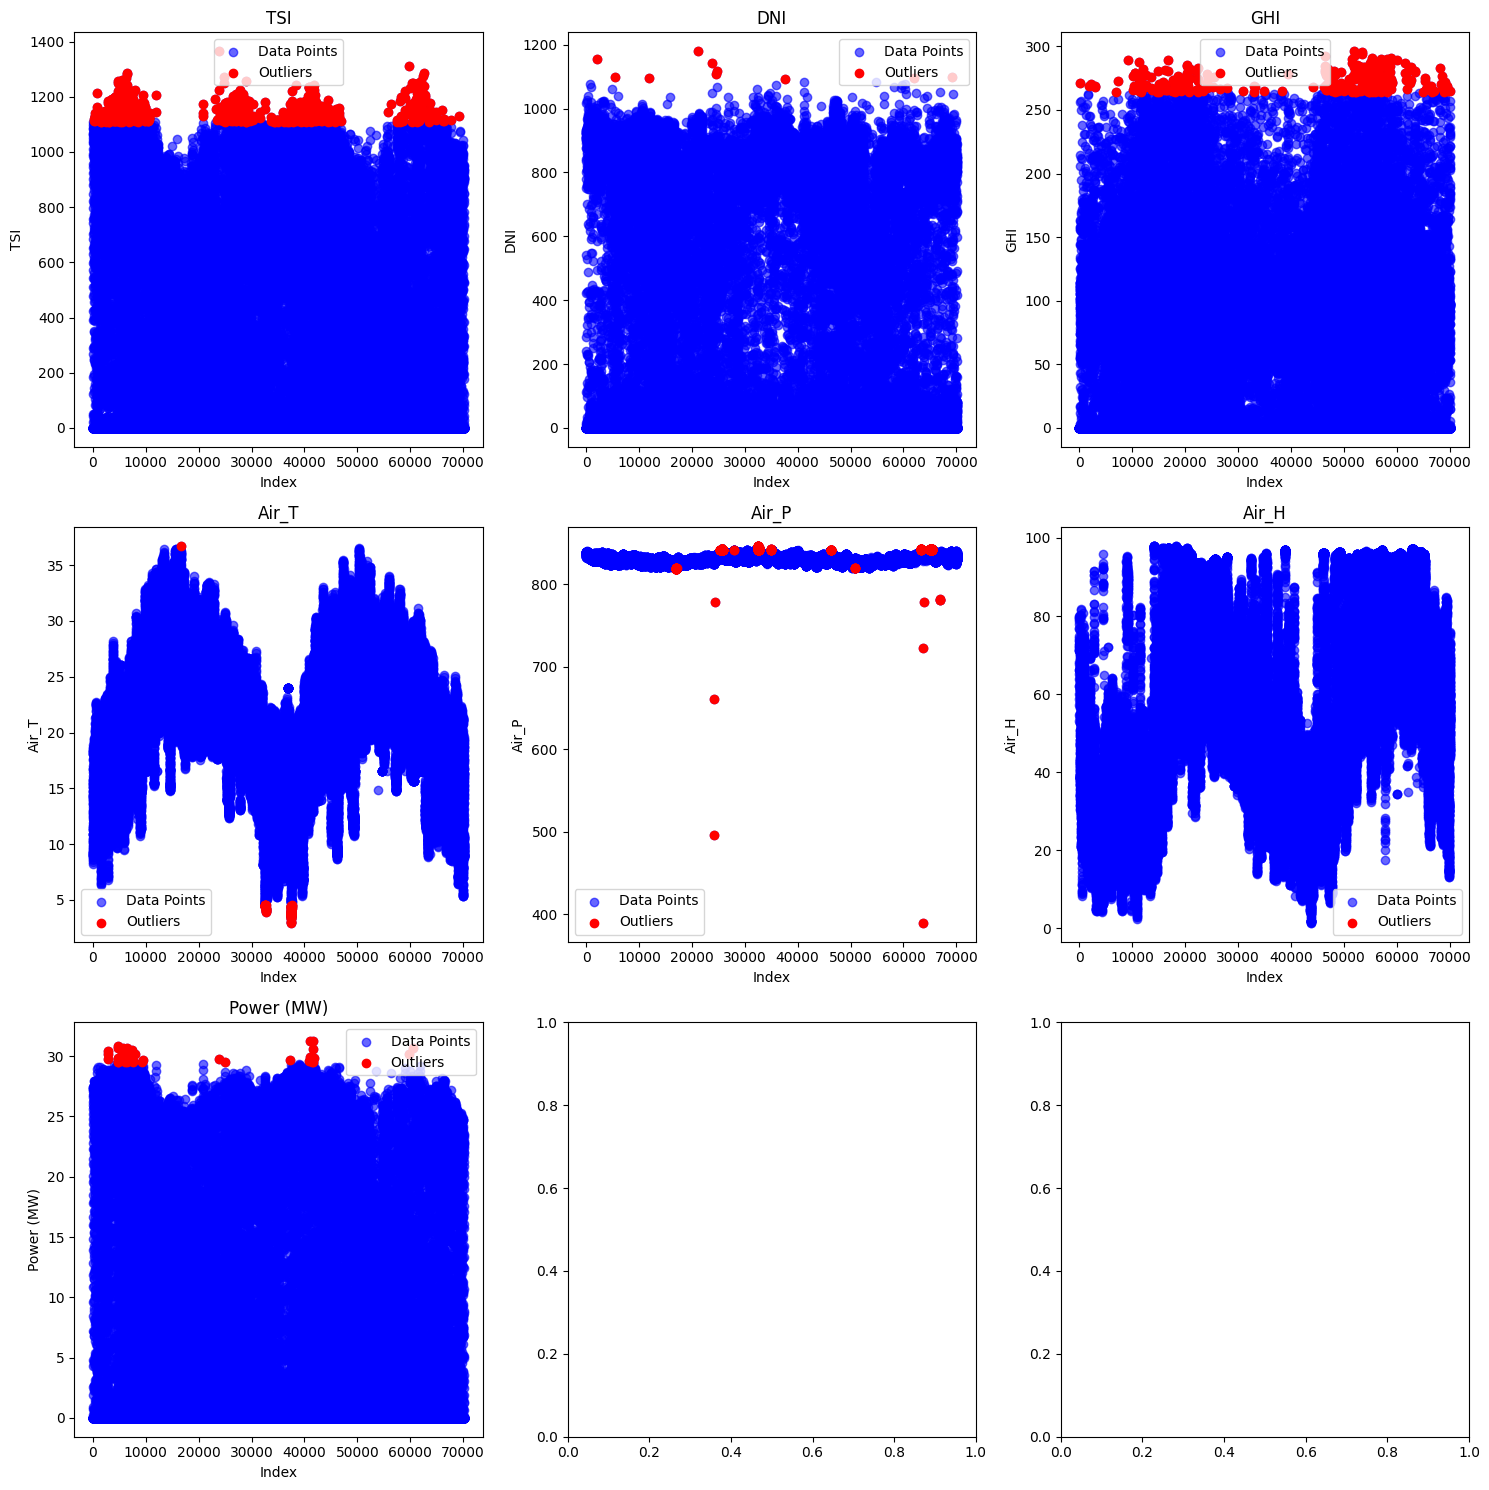

Total number of outliers found across all columns: 1969


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' and 'numerical_cols' are defined

# Function to identify outlier indices using IQR
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Initialize variables for tracking outliers
outlier_indices = {}  # Dictionary to store indices of outliers for each column
total_outliers = 0    # Counter for total outliers

# Compute outliers for each column
for col in numerical_cols:
    outliers = find_outliers_iqr(df[col])
    outlier_indices[col] = outliers.index.tolist()  # Store outlier indices
    total_outliers += len(outliers)  # Increment total outlier count

# Visualization of outliers for all numerical columns
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust grid size as needed
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i >= len(axes):  # Ensure we don't exceed the subplot limit
        break

    # Scatter plot of data points
    axes[i].scatter(df.index, df[col], label='Data Points', color='blue', alpha=0.6)

    # Highlight outliers in red
    outliers_in_col = df.loc[outlier_indices[col], col]  # Outlier data points
    axes[i].scatter(outliers_in_col.index, outliers_in_col, color='red', label='Outliers')

    # Set plot details
    axes[i].set_title(col)
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print the total number of outliers found
print(f"Total number of outliers found across all columns: {total_outliers}")


**2. Adjusting outliers using kNN imoutation method.**

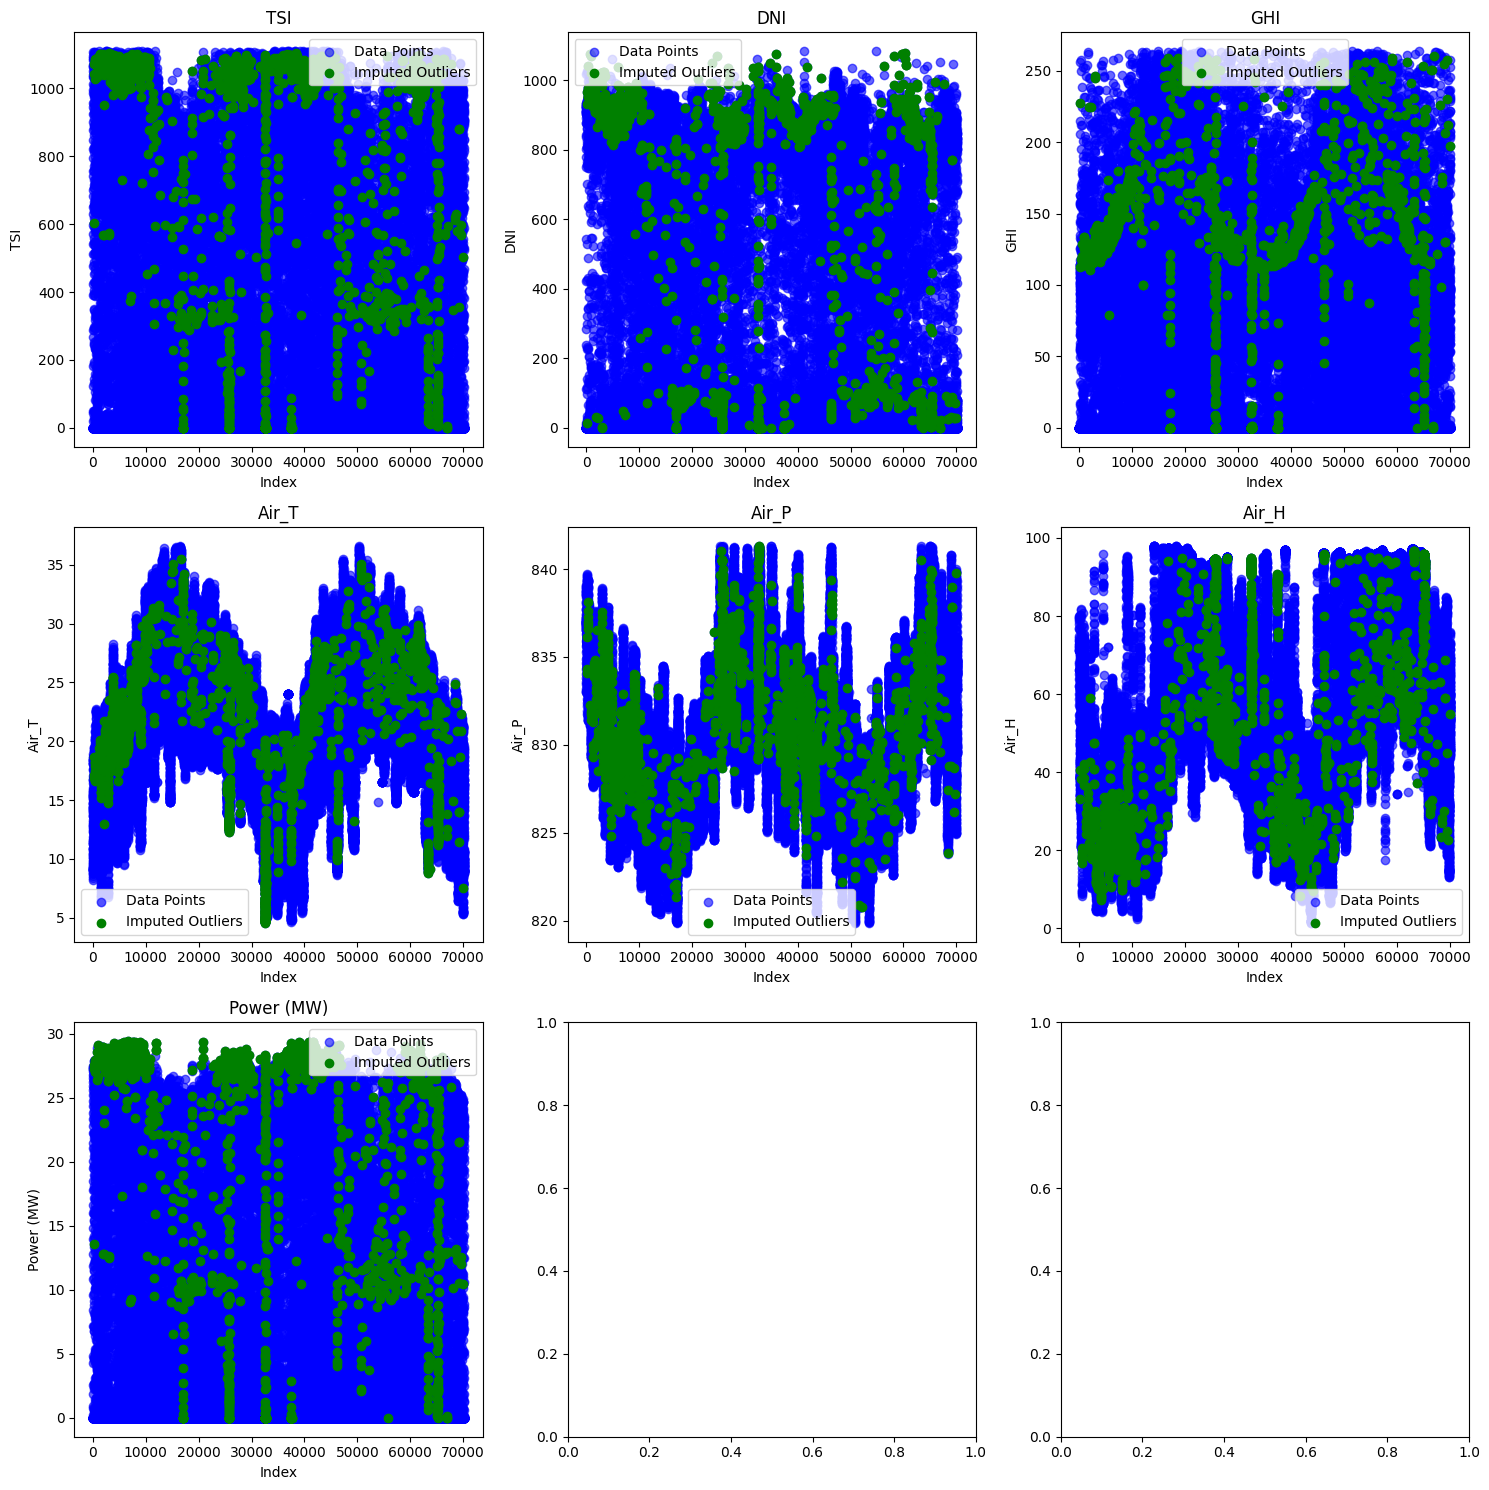

Total number of outliers replaced with KNN imputation: 1969


In [7]:
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' and 'numerical_cols' are defined

# Identify outlier indices using IQR
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)  # Adjust 'n_neighbors' as needed

# Replace outliers with KNN-imputed values
total_outliers_fixed = 0
imputed_outlier_indices = []  # Track imputed outlier indices for visualization

for col in numerical_cols:
    # Find outliers in the column
    outliers = find_outliers_iqr(df[col])
    outlier_indices = outliers.index.tolist()
    total_outliers_fixed += len(outlier_indices)
    imputed_outlier_indices.extend(outlier_indices)  # Add to the tracker

    # Mask the outliers in the column for imputation
    df.loc[outlier_indices, col] = None  # Mark outliers as NaN for imputation

# Apply KNN Imputer to the entire dataset
imputed_data = knn_imputer.fit_transform(df[numerical_cols])

# Update the DataFrame with the imputed values
df[numerical_cols] = pd.DataFrame(imputed_data, columns=numerical_cols)

# Scatter plot visualization of imputed outliers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust grid size as per the number of variables
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i >= len(axes):
        break

    # Scatter plot of data points
    axes[i].scatter(df.index, df[col], label='Data Points', color='blue', alpha=0.6)

    # Highlight imputed outliers in green
    fixed_outliers = [idx for idx in imputed_outlier_indices if idx in df.index]
    if len(fixed_outliers) > 0:
        axes[i].scatter(
            fixed_outliers,
            df.loc[fixed_outliers, col],
            color='green',
            label='Imputed Outliers'
        )

    axes[i].set_title(col)
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print the total number of outliers fixed
print(f"Total number of outliers replaced with KNN imputation: {total_outliers_fixed}")


## **Exploratory Data Analysis (EDA)**

###**Seasonal Power geneation trend (MW)**

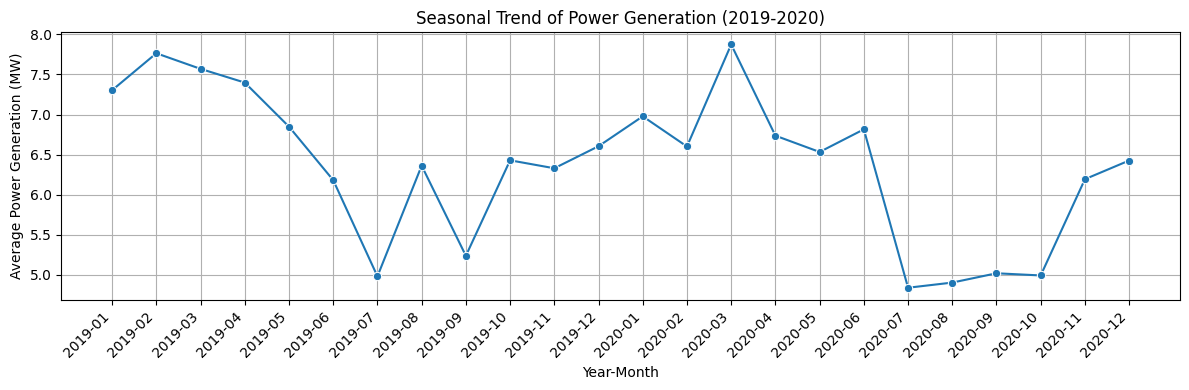

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'Power (MW)' is in numeric format
df['Power (MW)'] = pd.to_numeric(df['Power (MW)'], errors='coerce')

# Create a new column combining year and month for sequential plotting
df['year_month'] = df['time'].dt.to_period('M').astype(str)  # Convert to string

# Group data by year_month and calculate the mean of 'Power (MW)'
monthly_avg_power = df.groupby(['year_month'])['Power (MW)'].mean().reset_index()

# Plot the seasonal trend for both years sequentially
plt.figure(figsize=(12, 4))  # Adjust figure size for better readability
sns.lineplot(data=monthly_avg_power, x='year_month', y='Power (MW)', marker='o', linestyle='-')
plt.xlabel("Year-Month")
plt.ylabel("Average Power Generation (MW)")
plt.title("Seasonal Trend of Power Generation (2019-2020)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


## **Normalization**

**1. Drop 'year-month' variable**

We can drop the year-month variable since we don't need it for the subsequent stages.

In [9]:
if 'year_month' in df.columns:
  df = df.drop('year_month', axis=1)


**2. Robust scaler and Z-score Normalization of Numerical attributes:**

Robust scaling method works by adjusting the numerical data based on median and interquartile range (IGR), it is effective in containting outliers. Z-score normalization scales the numeric values between the rang of min -3 and max 3, this is also effective in containing outliers.

In [10]:
from sklearn.preprocessing import RobustScaler, StandardScaler

# Select numerical columns for normalization
numerical_cols_for_normalization = [col for col in numerical_cols if col not in ['Power (MW)']]


# Robust Scaler
robust_scaler = RobustScaler()
df[numerical_cols_for_normalization] = robust_scaler.fit_transform(df[numerical_cols_for_normalization])


# Z-Score Normalization (scaling to -3 and 3 range)
zscore_scaler = StandardScaler()
df[numerical_cols_for_normalization] = zscore_scaler.fit_transform(df[numerical_cols_for_normalization])

# Ensure the values are within the desired range
for col in numerical_cols_for_normalization:
    df[col] = df[col].clip(-3, 3)

print(df.head())


                 time       TSI       DNI      GHI     Air_T     Air_P  \
0 2019-01-01 00:00:00 -0.686934 -0.637884 -0.78201 -1.525394  1.674138   
1 2019-01-01 00:15:00 -0.686934 -0.637884 -0.78201 -1.577790  1.686903   
2 2019-01-01 00:30:00 -0.686934 -0.637884 -0.78201 -1.619706  1.676691   
3 2019-01-01 00:45:00 -0.686934 -0.637884 -0.78201 -1.628439  1.674138   
4 2019-01-01 01:00:00 -0.686934 -0.637884 -0.78201 -1.637171  1.646054   

      Air_H  Power (MW)  
0 -0.035945         0.0  
1  0.035492         0.0  
2  0.136343         0.0  
3  0.202317         0.0  
4  0.252743         0.0  


#**Model Training**

Autoencoders and LSTM for automatated feature selection, scaling and model training.

The model's evaluation metrics provide insights into its performance. The **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)** indicate how much the predictions deviate from actual values, with lower values suggesting better accuracy. **Mean Absolute Error (MAE)** measures the average absolute difference between predicted and actual power, showing how well the model predicts individual points. Finally, **R-squared (R²)** reflects how well the model captures variability in the data, with values closer to **1** indicating a strong correlation and good predictive power. If MSE and RMSE are high, the model might be **overfitting**, meaning it learns patterns too well but struggles with unseen data. Conversely, a low R² score suggests **underfitting**, where the model fails to recognize complex relationships. Based on these metrics, assessing whether the model generalizes well or needs improvements in training settings or feature engineering is key.

1644/1644 ━━━━━━━━━━━━━━━━━━━━ 195s 118ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step
Test MSE: 1.632011962810344
Test RMSE: 1.2775022359316417
Test MAE: 0.6797531697696213
Test R-squared: 0.9803107920768841


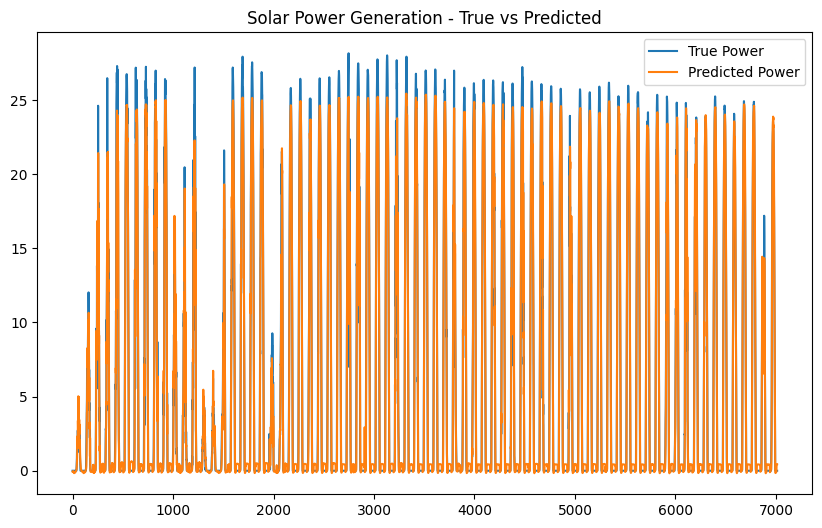

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Flag to skip training cell
skip_training = True  # Set this to True to skip training and load the model

# Define RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Hyperparameters
SEQ_LENGTH = 48
NUM_LSTM_NEURONS = 200
LEARNING_RATE = 0.01
NUM_LAYERS = 3
BATCH_SIZE = 128
DROPOUT_RATE = 0.2
EPOCHS = 50
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
ACTIVATION_FUNCTION = 'tanh'
LOSS_FUNCTION = 'mse'

# Preprocess 'time' column
df['time'] = pd.to_datetime(df['time'])
# Extract temporal features from the 'time' column
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['week'] = df['time'].dt.isocalendar().week
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['time'] = df['time'].astype('int64') // 10**9

# Convert numerical object columns to float64
for col in df.columns:
    if col != 'time':
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')

# Feature selection
features = ['TSI', 'DNI', 'GHI', 'Air_T', 'Air_P', 'Air_H', 'hour', 'day_of_week', 'week', 'month', 'year']
target_variable = 'Power (MW)'

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

df[features] = scaler.fit_transform(df[features])
df[[target_variable]] = target_scaler.fit_transform(df[[target_variable]])

data = df[features + [target_variable]].values

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        xs.append(data[i:(i + seq_length), :-1])
        ys.append(data[i + seq_length, -1])
    return np.array(xs), np.array(ys)

X, y = create_sequences(data, SEQ_LENGTH)

# Split the data
train_size = int(len(X) * 0.75)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Build and train the model
if not skip_training:
    model = Sequential()
    model.add(Input(shape=(SEQ_LENGTH, len(features))))
    for i in range(NUM_LAYERS):
        model.add(LSTM(NUM_LSTM_NEURONS, activation=ACTIVATION_FUNCTION, return_sequences=True if i < NUM_LAYERS - 1 else False))
        model.add(Dropout(DROPOUT_RATE))

    model.add(Dense(1))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=[rmse])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])
    model.save('model2.keras')

else:
    model = load_model('model2.keras', custom_objects={'rmse': rmse})

# Evaluate the model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_train = target_scaler.inverse_transform(y_pred_train)
y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))

y_pred_test = target_scaler.inverse_transform(y_pred_test)
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred_test)
rmse_value = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse_value}")
print(f"Test MAE: {mae}")
print(f"Test R-squared: {r2}")




plt.figure(figsize=(10,6))
plt.plot(y_test, label='True Power')
plt.plot(y_pred_test, label='Predicted Power')
plt.title("Solar Power Generation - True vs Predicted")
plt.legend()
plt.show()

###**Model Classification Test**


In [12]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Convert continuous values into binary (high/low power) for Precision, Recall, Accuracy
threshold = np.median(y_test)  # Median as the threshold for classification
y_test_class = (y_test > threshold).astype(int)  # 1 for high power, 0 for low power
y_pred_test_class = (y_pred_test > threshold).astype(int)  # Same for predictions

# Calculate Precision, Recall, and Accuracy
accuracy = accuracy_score(y_test_class, y_pred_test_class)
precision = precision_score(y_test_class, y_pred_test_class)
recall = recall_score(y_test_class, y_pred_test_class)


# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")



Accuracy: 0.6694709824611436
Precision: 0.5701819532120312
Recall: 0.9990240728692258


#**Model Testing**


##**Perfomance Test**

##**1. Performance Tests (PT)**
Model sensitivity or robustness testing evaluates how well the model performs under extreme or unexpected conditions, such as sudden weather changes (e.g., cloud cover) or sensor failures. This ensures the model is reliable in real-world scenarios where data quality or conditions may not be ideal.

**Scenario:** Simulate a sudden drop in solar irradiance (e.g., due to cloud cover) and evaluate the model’s predictions. Based on the following:


1.   Sensitivity performance Test
2.   Prediction Errors based on Power(MW)
3.   Day and Night performance


**Accountability:** Document the model’s performance under these conditions and ensure it provides reasonable predictions. If the model fails, identify the root cause (e.g., over-reliance on irradiance data) and improve the training data or model architecture.






Error: 1970-01-01 00:00:00 not found in data. Please check the time format or data availability.
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step
Test MSE under simulated drop: 0.007585174075604044
Test RMSE under simulated drop: 0.08709290485225558


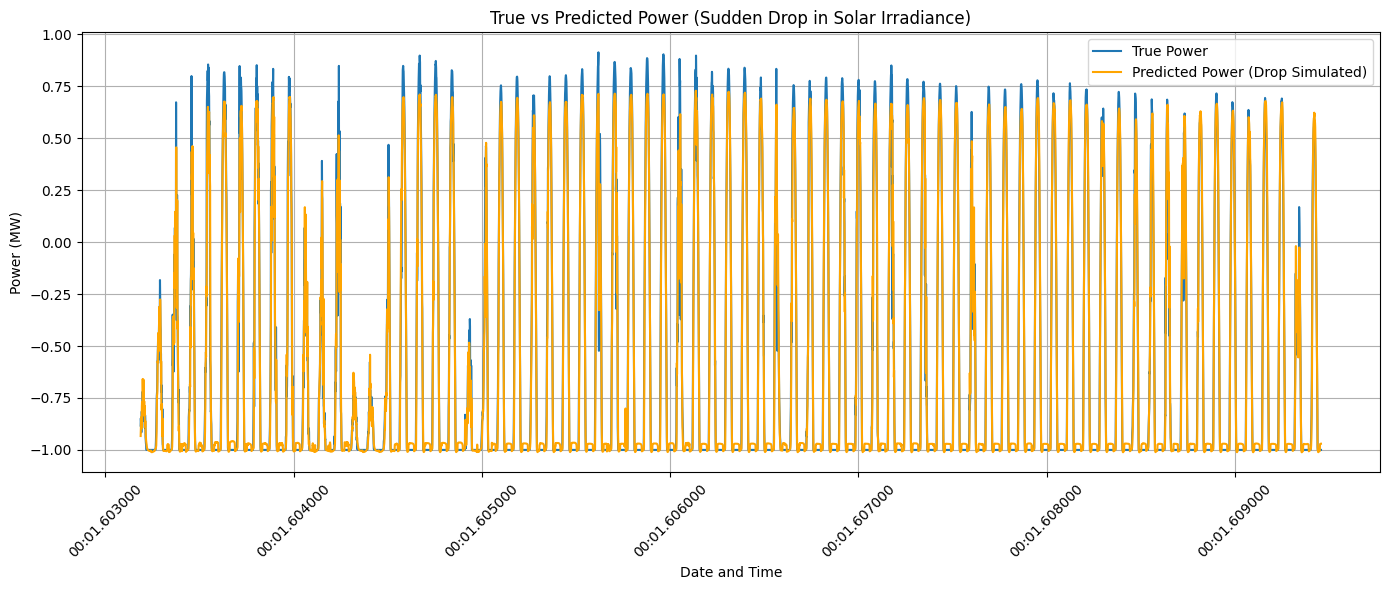

Number of significant prediction errors (above 0.5 MW): 32


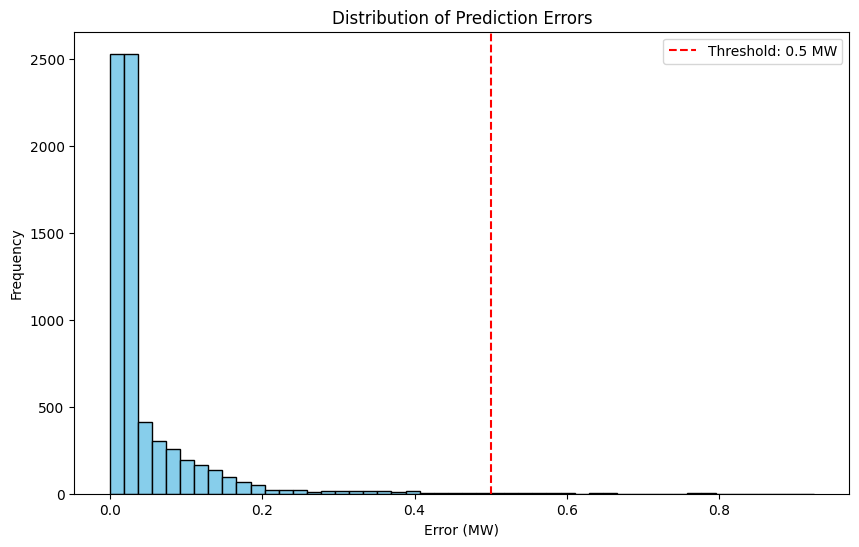

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import random

# Simulating a sudden drop in solar irradiance (cloud cover scenario)
def simulate_sudden_drop(df, drop_factor=0.2, start_time="2020-02-20", duration=12):
    """Simulate a sudden drop in solar irradiance data."""
    df['time'] = pd.to_datetime(df['time'])
    start_time = pd.to_datetime(start_time)

    if start_time not in df['time'].values:
        print(f"Error: {start_time} not found in data. Please check the time format or data availability.")
        return df

    start_idx = df[df['time'] == start_time].index[0]
    end_idx = start_idx + (duration * 4)

    df.loc[start_idx:end_idx, ['TSI', 'DNI', 'GHI']] *= drop_factor

    return df

# Load model and scaler (ensure paths are correct)
model = load_model('model2.keras', custom_objects={'rmse': rmse})

# Define relevant features and target
features = ['TSI', 'DNI', 'GHI', 'Air_T', 'Air_P', 'Air_H', 'hour', 'day_of_week', 'week', 'month', 'year']
target_variable = 'Power (MW)'

# **Random 3-day Period Selection (from testing data)**

# Ensure 'time' column is datetime type
df['time'] = pd.to_datetime(df['time'])

# Select 10% of the dataset for testing purposes (this avoids out-of-scope errors)
test_data = df[-int(len(df) * 0.1):]

# Randomly pick a 3-day period within the test data range
start_date = random.choice(test_data['time'].dt.date.unique())
end_date = start_date + pd.Timedelta(days=2)

# Slice the 3-day period from the data
test_data_period = test_data[(test_data['time'].dt.date >= start_date) & (test_data['time'].dt.date <= end_date)]

# **Simulate Sudden Drop on the 3-day Period**
drop_factor = 0.2
modified_df = simulate_sudden_drop(test_data_period.copy(), drop_factor=drop_factor, start_time=start_date, duration=12)

# **Fit the Scalers on the Original Data (Training Data)**
scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

df[features] = scaler.fit_transform(df[features])
df[[target_variable]] = target_scaler.fit_transform(df[[target_variable]])

modified_df[features] = scaler.transform(modified_df[features])
modified_df[[target_variable]] = target_scaler.transform(modified_df[[target_variable]])

# **Prepare the Sequence Data for Model Input**
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        xs.append(data[i:(i + seq_length), :-1])  # features
        ys.append(data[i + seq_length, -1])  # target
    return np.array(xs), np.array(ys)

modified_data = modified_df[features + [target_variable]].values
SEQ_LENGTH = 48  # Assuming a 12-hour window
X_modified, y_modified = create_sequences(modified_data, SEQ_LENGTH)

# **Model Predictions on Modified Data**
y_pred_modified = model.predict(X_modified)
y_pred_modified = target_scaler.inverse_transform(y_pred_modified)

# Evaluate the Performance
y_modified = target_scaler.inverse_transform(y_modified.reshape(-1, 1))

# Calculate MSE and RMSE for predictions under the simulated drop
mse_modified = mean_squared_error(y_modified, y_pred_modified)
rmse_modified = np.sqrt(mse_modified)

print(f"Test MSE under simulated drop: {mse_modified}")
print(f"Test RMSE under simulated drop: {rmse_modified}")

# **Fix the mismatch in lengths between time and target for plotting**
# Use the time range corresponding to the prediction sequence

# Slice the time range to match the sequence data length
modified_time_range = modified_df['time'].iloc[SEQ_LENGTH:len(y_modified) + SEQ_LENGTH].values

# **Plotting Results - Simulated Drop Test**
plt.figure(figsize=(14, 6))
plt.plot(modified_time_range, y_modified, label='True Power')
plt.plot(modified_time_range, y_pred_modified, label='Predicted Power (Drop Simulated)', color='orange')
plt.title("True vs Predicted Power (Sudden Drop in Solar Irradiance)")
plt.xlabel("Date and Time")
plt.ylabel("Power (MW)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Identify the Model's Response to Sudden Drop in Irradiance**
def analyze_predictions(y_true, y_pred, threshold=0.5):
    """Analyze the model's response to extreme conditions with a dynamic threshold."""
    # Calculate the absolute error between true and predicted values
    error = np.abs(y_true - y_pred)

    # Identify where the model's error exceeds the new threshold
    significant_error = error > threshold

    print(f"Number of significant prediction errors (above {threshold} MW): {np.sum(significant_error)}")

    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(error, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold: {threshold} MW")  # Update threshold label dynamically
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Error (MW)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# **Run the updated function with threshold = 0.5**
analyze_predictions(y_modified, y_pred_modified, threshold=0.5)


###**PT-1. Sensitivity Performance Test**


###**PT-2. Prediction Errors in Power(MW)**


###**PT-3. Day and Night performance:**


##**2. Model Explainability**

###**ME-1. SHAP Explanation Plot**

Just like in our M1 model, we applied the same sensitivity test by simulating a sudden drop in the TSI to see how the model performs by looking at the features contributing the most via SHAP plot. The plot shows that TSI(TSI_t47) came as the 1st feature-timestep and the GHI(GHI_t47) as the 2nd feature, where TSI_t47 contributes to the prediction with upto 0.125 high SHAP values and GHI_t47 with upto 0.075 high SHAP values positively with low SHAP values below -0.025 for both features. The 3rd and 4th feature contribution is the **hour** feature, with hour_t47 feature having SHAP values with positive impact of upto 0.05 with less than -0.025 negetive impact and hour_t46 feature-timestep having more negetive impact with upto -0.025 respectively. The 5th feature-timesteps is once again the TSI_t46 with almost eqaul distribution of both positive and negative SHAP values. The remaining feature-timesteps in the SHAP plot falls between 0.025 and -0.025 impact level respectively. In summary there are total of 20 feature-timesteps where top 5 features contributing with SHAP values above the range of 0.025 both positively and negetively with hour feature having contributed with upto 11 timesteps. TSI and GHI features having contributed with upto 4 timesteps each and lastly DNI contributed with only 1 timestep (DNI_t47).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
856/856 ━━━━━━━━━━━━━━━━━━━━ 114s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
855/855 ━━━━━━━━━━━━━━━━━━━━ 250s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
855/855 ━━━━━━━━━━━━━━━━━━━━ 129s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 108s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 107s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 105s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 113s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 109s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 107s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 106s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 104s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
854/854 ━━━━━━━━━━━━━━━━━━━━ 107s 125

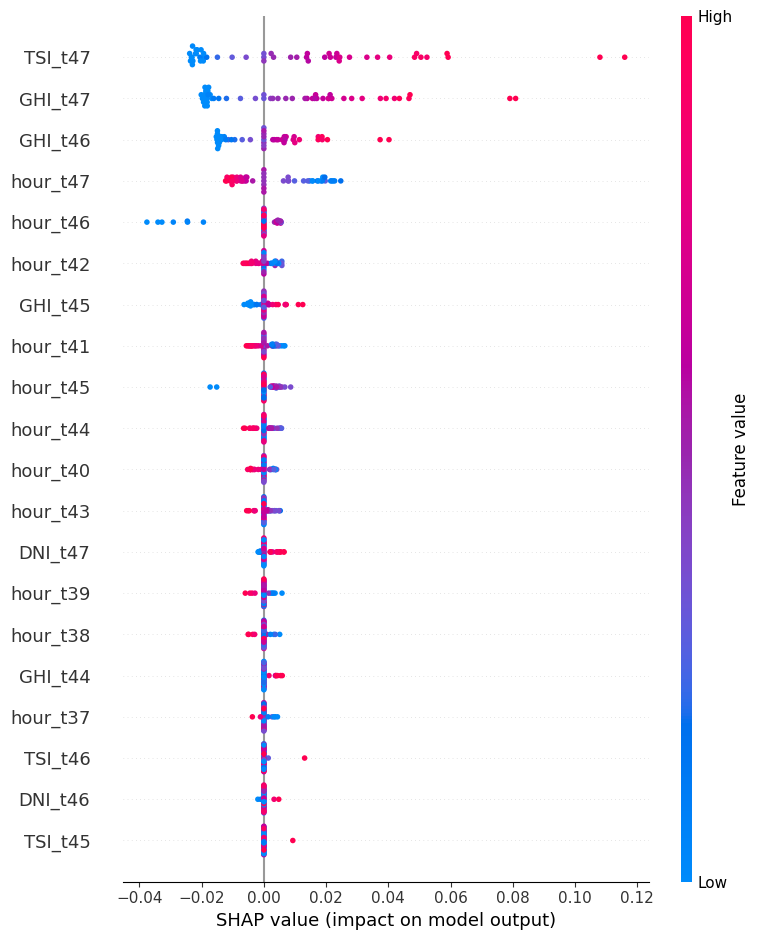

In [16]:
if RUN_SHAP_SUMMARY:
  import shap
  import numpy as np
  import matplotlib.pyplot as plt

  # --- Step 1: Reshape inputs for KernelExplainer (requires 2D inputs) ---
  sample_to_explain = X_modified[:50]  # Keep this small due to performance (adjust as needed)
  X_flat = sample_to_explain.reshape(sample_to_explain.shape[0], -1)

  # --- Step 2: Define model prediction wrapper ---
  f = lambda x: model.predict(x.reshape((-1, SEQ_LENGTH, len(features)))).flatten()

  # --- Step 3: Create background data for KernelExplainer ---
  background = X_flat[np.random.choice(X_flat.shape[0], 10, replace=False)]

  # --- Step 4: Create SHAP explainer and compute values ---
  explainer = shap.KernelExplainer(f, background)
  shap_values = explainer.shap_values(X_flat)

  # --- Step 5: Visualize SHAP summary (global importance) ---
  flattened_feature_names = [f"{feature}_t{t}" for t in range(SEQ_LENGTH) for feature in features]
  shap.summary_plot(shap_values, X_flat, feature_names=flattened_feature_names)
else:
    print("SHAP summary skipped. Set RUN_SHAP_SUMMARY = True to run.")

##**ME-2. SHAP Value strength over timesteps**

In this plot, we aim to see the magnitude of mean absolute SHAP values contributing to the prediction per timestep. As we can see from the chart there is a slight raise in the shap vvalues from timestep 40 and above. This also explains why we see the SHAP plot timesteps are above t30 with t47 as highest.

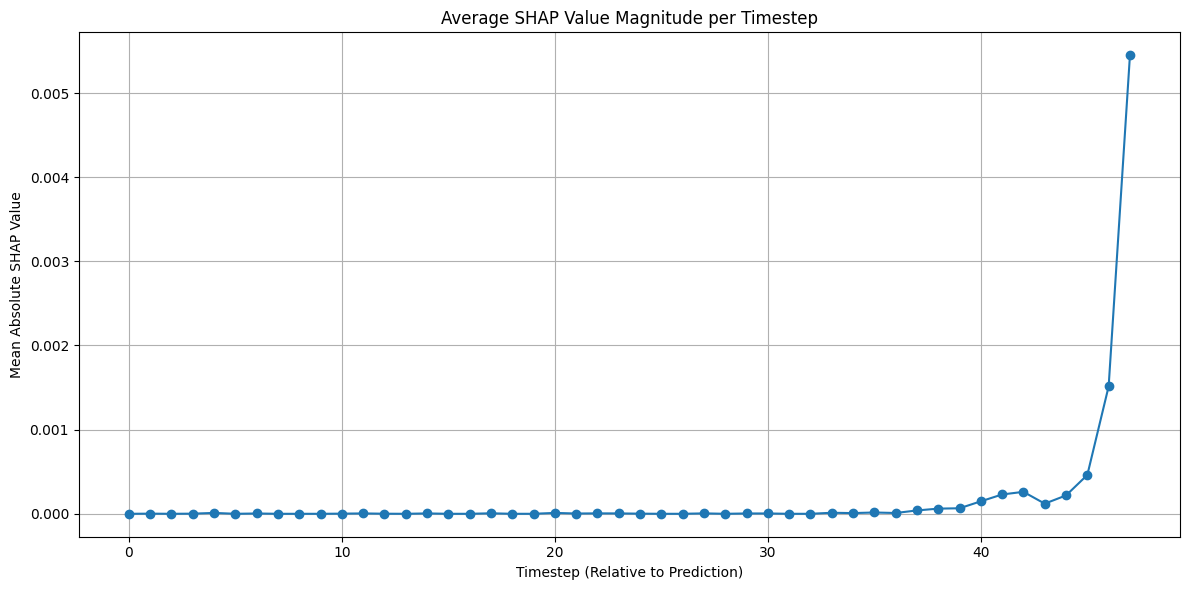

In [17]:
 if RUN_SHAP_SUMMARY:
  # --- Step 6: Analyze SHAP Value Strength Over Time ---
  shap_array = np.array(shap_values).reshape(sample_to_explain.shape[0], SEQ_LENGTH, len(features))

  # Average absolute SHAP value across samples for each time step
  mean_shap_per_timestep = np.abs(shap_array).mean(axis=(0, 2))

  # Plotting
  plt.figure(figsize=(12, 6))
  plt.plot(range(SEQ_LENGTH), mean_shap_per_timestep, marker='o')
  plt.title("Average SHAP Value Magnitude per Timestep")
  plt.xlabel("Timestep (Relative to Prediction)")
  plt.ylabel("Mean Absolute SHAP Value")
  plt.grid(True)
  plt.tight_layout()
  plt.show()
else:
      print("SHAP summary skipped. Set RUN_SHAP_SUMMARY = True to run.")